In [293]:
import pandas as pd
import numpy as np
from scipy import optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [166]:
data = pd.read_csv('data.csv', na_values = '.')
data['PCECC96'] = pd.to_numeric(data['PCECC96'])
data['WILL5000IND'] = pd.to_numeric(data['WILL5000IND'])
data['GDPDEF'] = pd.to_numeric(data['GDPDEF'])
data['TB3MS'] = pd.to_numeric(data['TB3MS'])
data.head(5)

,DATE,PCECC96,WILL5000IND,GDPDEF,TB3MS
0,1971-01-01,3156.978,NaN,22.391,3.840000
1,1971-04-01,3185.993,1.136667,22.685,4.250000
2,1971-07-01,3211.394,1.113333,22.916,5.010000
3,1971-10-01,3264.679,1.113333,23.107,4.230000
4,1972-01-01,3307.767,1.240000,23.458,3.436667


In [167]:
data = data.rename(columns = {'PCECC96': 'Consumption',\
                       'TB3MS': 'Tbill',\
                       'WILL5000IND': 'Return',\
                       'GDPDEF': 'Deflator'})
data.head(5)

,DATE,Consumption,Return,Deflator,Tbill
0,1971-01-01,3156.978,NaN,22.391,3.840000
1,1971-04-01,3185.993,1.136667,22.685,4.250000
2,1971-07-01,3211.394,1.113333,22.916,5.010000
3,1971-10-01,3264.679,1.113333,23.107,4.230000
4,1972-01-01,3307.767,1.240000,23.458,3.436667


In [168]:
data.insert(5, "Real Return", \
            (1 + data['Return'].pct_change())/ \
            (1 + data['Deflator'].pct_change()) )
data.insert(6, "Real Tbill", \
            (1 + data['Tbill'].pct_change())/ \
            (1 + data['Deflator'].pct_change()) )
data.head(5)

,DATE,Consumption,Return,Deflator,Tbill,Real Return,Real Tbill
0,1971-01-01,3156.978,NaN,22.391,3.840000,NaN,NaN
1,1971-04-01,3185.993,1.136667,22.685,4.250000,NaN,1.092427
2,1971-07-01,3211.394,1.113333,22.916,5.010000,0.969599,1.166941
3,1971-10-01,3264.679,1.113333,23.107,4.230000,0.991734,0.837332
4,1972-01-01,3307.767,1.240000,23.458,3.436667,1.097107,0.800294


In [246]:
data = data.set_index('DATE')
data.head(5)

,Consumption,Return,Deflator,Tbill,Real Return,Real Tbill
DATE,,,,,,
1971-01-01,3156.978,NaN,22.391,3.840000,NaN,NaN
1971-04-01,3185.993,1.136667,22.685,4.250000,NaN,1.092427
1971-07-01,3211.394,1.113333,22.916,5.010000,0.969599,1.166941
1971-10-01,3264.679,1.113333,23.107,4.230000,0.991734,0.837332
1972-01-01,3307.767,1.240000,23.458,3.436667,1.097107,0.800294


In [170]:
# some functions
mu = lambda c, γ: c**(-γ)
u = lambda c, γ: c**(1-γ)/(1-γ)

### 1. Compute $\gamma$

In [265]:
β = 0.99

def SDF(γ, ct, ctp1):
    
    mtp1 = β * mu(ct, γ) / mu(ctp1, γ)
    
    return mtp1

def func5(γ):
    
    M = SDF(γ,data['Consumption'], data['Consumption'].shift(1))
    R = data['Real Return']
    
    EM = M.mean(skipna = True)
    ER = R.mean(skipna = True)
    
    covar = R.cov(M)
    
    f1 = covar + EM * ER - 1
    
    return f1

func5(0.5)

0.004973650621856729

In [266]:
opt.broyden1(func5, 1)

array(1.15788216)

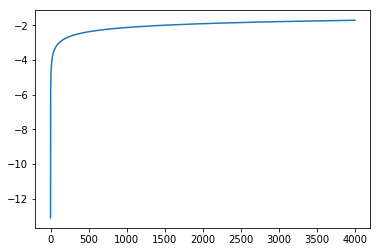

In [206]:
plt.plot(np.linspace(0.01, 4000, 4000), u(np.linspace(0.01, 4000, 4000), 1.15788216))

### 2. Reasonable?
- I think this is reasonable, as we have the utility function convex, and is reasonablly flat when it gets away from 0.
- If really want to determine, run lab experiments or take this parameter to other places and see whether that matches with the data or not.

### 3. use moment restriction equation 7

In [278]:
def func7(γ):
    
    M = SDF(γ,data['Consumption'], data['Consumption'].shift(1)).dropna()
    Rf = data['Real Tbill'].dropna()/100 # no convergence if I do not divide it by 100
    EM = M.mean()
    ERf = Rf.mean()
    
    f = 1/EM - 1 - ERf
    
    return f

func7(0.5)

0.0035138436140952946

In [279]:
opt.broyden1(func7, 1)

array(0.03196192)

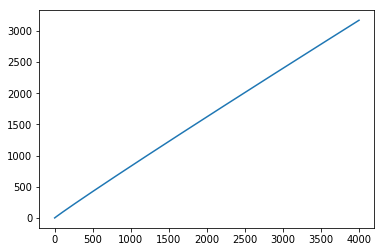

In [280]:
plt.plot(np.linspace(0.01, 4000, 4000), u(np.linspace(0.01, 4000, 4000), 0.03196192))

- the $\gamma$ is very small, which makes sense as now we are using the risk-free rate, and there should be no risk aversion.

### 4: Using both equations 5 and 7

In [285]:
def funcs57(γ, β):
    M = SDF(γ,data['Consumption'], data['Consumption'].shift(1))
    R = data['Real Return']
    Rf = data['Real Tbill'].dropna()/100
    
    covar = R.cov(M)
    EM = M.mean(skipna = True)
    ER = R.mean(skipna = True)
    ERf = Rf.mean()
    
    funcs = np.zeros((1,2))
    funcs[0, 0] = covar + EM*ER - 1
    funcs[0, 1] = 1 + ERf - 1/EM
    
    return funcs

def find_γ_GMM(γ, W, β):
    moments = funcs57(γ,β)
    weighted_moments = moments.dot(W).dot(moments.T)
    
    return weighted_moments

In [287]:
# First use identity matrix to calculate the first-stage GMM estimator
W = np.identity(2)
f3 = lambda γ: find_γ_GMM(γ,W,β)
opt.minimize(f3,2).x

array([0.58805567])

- with both conditions and identity weighting matrix, we have a $\gamma$ between the above 2, which makes sense.

In [298]:
def func_final(γ, β):
    
    moments = funcs57(opt.minimize(f3,2).x,β)
    w_optimal = np.linalg.inv(1/2*moments.T.dot(moments))
    func = lambda γ, β: find_γ_GMM(γ,w_optimal,β)
    gamma = np.vectorize(func)(γ, β)
    
    return gamma

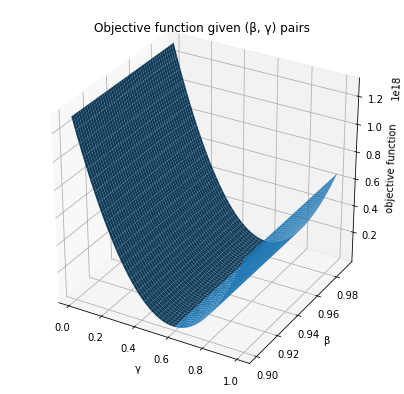

In [303]:
γγ = np.linspace(.01, 1, 50)
ββ = np.linspace(.9, .99, 50)
Y, B = np.meshgrid(γγ,ββ)
func = func_final(Y, B)

fig = plt.figure(figsize = (7,7))
ax = fig.gca(projection='3d')
ax.plot_surface(Y, B, func)
ax.set_xlabel('γ')
ax.set_ylabel('β')
ax.set_zlabel('objective function')
ax.set_title('Objective function given (β, γ) pairs')
plt.show()